# Redes Bayesianas y Teoría de la Decisión

## Metodología TZERPIC

---

### **T - Tema (Topic)**
**Redes Bayesianas para predicción de diabetes y toma de decisiones bajo incertidumbre**

Este notebook aborda la construcción de una Red Bayesiana para modelar factores de riesgo de diabetes, y su extensión a un **Diagrama de Influencia** mediante la incorporación de nodos de decisión y utilidad para recomendar dietas basadas en el índice glucémico.

---

### **Z - Zoom (Enfoque)**
**Dos componentes principales:**

| Componente | Propósito | Elementos |
|------------|-----------|-----------|
| **Red Bayesiana** | Modelar probabilidades condicionales de diabetes | 10 nodos (Overweight, Age, Pregnancies, etc.) |
| **Diagrama de Influencia** | Tomar decisiones óptimas de alimentación | Nodo de decisión (GI) + Nodo de utilidad |

---

### **E - Evidencia (Evidence)**
**Datos y parámetros del problema:**

- **Dataset:** `diabetes-dataset.csv` con variables de salud
- **Variables:** Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, DiabetesPedigreeFunction, Age, Outcome
- **Discretización:** Por cuartiles (Q1, Q2, Q3) → valores {0, 1, 2, 3}
- **Variable derivada:** `Overweight` (BMI > 25)

---

### **R - Razonamiento (Reasoning)**
**Modelos matemáticos implementados:**

1. **Probabilidades Condicionales** - Para cada nodo dado sus padres:
$$P(X|Pa(X)) = \frac{\text{count}(X, Pa(X))}{\text{count}(Pa(X))}$$

2. **Inferencia Bayesiana** - Actualización de creencias con evidencia:
$$P(X|E) \propto P(E|X) \cdot P(X)$$

3. **Principio de Máxima Utilidad Esperada (MEU)** - Para toma de decisiones:
$$EU(a) = \sum_{s} P(s|E) \cdot U(s, a)$$
$$a^* = \arg\max_{a} EU(a)$$

---

### **P - Propuesta (Proposal)**

#### Parte 1: Red Bayesiana
| Función | Propósito |
|---------|-----------|
| `discretize()` | Discretiza variables continuas por cuartiles |
| `probabilities()` | Calcula probabilidades marginales/condicionales |
| `tables()` | Genera tablas de probabilidad para todos los nodos |
| `print_probs()` | Visualiza distribuciones marginales |
| `evidence()` | Añade evidencia para inferencia |

#### Parte 2: Teoría de la Decisión ⭐ *Project of the Week*
| Función | Propósito |
|---------|-----------|
| `utility_function()` | Define U(estado, acción) según tabla de utilidad |
| `maximize_utility()` | Encuentra la acción que maximiza EU |

**Tabla de Utilidad:**

| Estado/Acción | Low GI | Medium GI | High GI |
|---------------|--------|-----------|---------|
| No Diabético (0) | 60 | 100 | 80 |
| Diabético (1) | 100 | 50 | 0 |

---

### **I - Implementación (Implementation)**
**Flujo del notebook:**

```
1. Cargar y preprocesar datos
        ↓
2. Crear variable Overweight (BMI > 25)
        ↓
3. Discretizar variables por cuartiles
        ↓
4. Definir topología de la red (graph)
        ↓
5. Calcular tablas de probabilidad
        ↓
6. Construir Red Bayesiana con pybbn
        ↓
7. Realizar inferencias con evidencia
        ↓
=============== PROJECT OF THE WEEK ===============
        ↓
8. Definir acciones: {Low GI, Medium GI, High GI}
        ↓
9. Implementar función de utilidad U(s,a)
        ↓
10. Calcular Utilidad Esperada: EU(a) = Σ P(s|E)·U(s,a)
        ↓
11. Seleccionar acción óptima: a* = argmax EU(a)
```

---

### **C - Conclusión (Conclusion)**
**Resultados esperados:**

- **Red Bayesiana:** Inferir probabilidad de diabetes dados factores como sobrepeso, edad, embarazos, etc.
- **Teoría de la Decisión:** Recomendar el tipo de alimento (según índice glucémico) que maximiza la utilidad esperada del paciente.

**Escenarios de prueba:**
- *No diabético (P=1.0):* Óptimo → **Medium GI** (U=100)
- *Diabético (P=1.0):* Óptimo → **Low GI** (U=100)
- *Incierto (P=0.5):* Óptimo → **Low GI** (EU=80)

**Aplicaciones reales:** Sistemas de recomendación médica, diagnóstico asistido, planificación de tratamientos personalizados.

---

# Solution Template

Use this notebook as a guide to implement your solution. Keep in mind that some cells should remain as they are so that you code works properly, for instance, the following cell in which the required libraries are imported. However, you can add more cells in case that is necessary.

In [1]:
import pandas as pd
import numpy as np
import networkx as nx # for drawing graphs
import matplotlib.pyplot as plt # for drawing graphs
from pybbn.graph.dag import Bbn # for creating Bayesian Belief Networks (BBN)
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

Just run the next cell to load the data.

In [2]:
diabetes = pd.read_csv('diabetes-dataset.csv')
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,2,138,62,35,0,33.6,0.127,47,1
1,0,84,82,31,125,38.2,0.233,23,0
2,0,145,0,0,0,44.2,0.630,31,1
3,0,135,68,42,250,42.3,0.365,24,1
4,1,139,62,41,480,40.7,0.536,21,0


Create a new column called `Overweight` in which a person whose `BMI` is above 25 will be tagged as a one, and zero otherwise.

In [3]:
# Create Overweight column: 1 if BMI > 25 else 0
diabetes['Overweight'] = (diabetes['BMI'] > 25).astype(int)
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Overweight
0,2,138,62,35,0,33.6,0.127,47,1,1
1,0,84,82,31,125,38.2,0.233,23,0,1
2,0,145,0,0,0,44.2,0.630,31,1,1
3,0,135,68,42,250,42.3,0.365,24,1,1
4,1,139,62,41,480,40.7,0.536,21,0,1


You are to code the next function, which discretize all the variables of the dataset, except `Outcome` and `Overweight`. Remember that you will discretize with respect to the quantiles of each variables: if a variable value is less than Q1, then said value is replaced by a **zero**; if the given value is greater or equal than Q1 but less than Q2, then the value should be replaced by a **one**; if the variable value is greater or equal than Q2 but less than Q3, then the value should be replaced by a **two**; finally, if a variable value is greater than Q3, it should be assigned the value **three**. 

In [4]:
def discretize(df):
    
    """
    This function receives a dataframe as input and returns a dataframe in which each variable has been 
    discretized. 
    """
    
    # Work on a copy to avoid modifying the original dataframe
    discretized_df = df.copy()
    
    # Columns to discretize (exclude Outcome and Overweight)
    cols = [c for c in df.columns if c not in ('Outcome', 'Overweight')]
    
    for c in cols:
        q1 = df[c].quantile(0.25)
        q2 = df[c].quantile(0.5)
        q3 = df[c].quantile(0.75)
        
        # Apply the rules:
        # value < Q1 -> 0
        # Q1 <= value < Q2 -> 1
        # Q2 <= value < Q3 -> 2
        # value >= Q3 -> 3
        conds = [
            df[c] < q1,
            (df[c] >= q1) & (df[c] < q2),
            (df[c] >= q2) & (df[c] < q3),
            df[c] >= q3
        ]
        choices = [0, 1, 2, 3]
        
        discretized_df[c] = np.select(conds, choices).astype(int)
    
    return discretized_df

In [5]:
discrete_df = discretize(diabetes)
discrete_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Overweight
0,1,2,0,3,1,2,0,3,1,1
1,0,0,3,2,2,3,0,0,0,1
2,0,3,0,1,1,3,3,2,1,1
3,0,2,1,3,3,3,1,1,1,1
4,1,2,0,3,3,3,2,0,0,1
...,...,...,...,...,...,...,...,...,...,...
1995,1,0,1,2,2,1,1,2,0,1
1996,3,3,2,3,3,2,3,2,1,1
1997,3,0,2,1,1,1,2,3,0,1
1998,0,2,3,3,3,3,1,1,1,1


In the following cel you are to create two dictionaries: `graph` will store the topology of the Bayesian network, so each element is associated to a list that contains the names of the parents of said element; `values` stores the values that each variable of the network takes, which are the discrete values that were computed above.

In [6]:
# Create graph (topology: empty parent lists for now) and values (discrete values for each variable)
cols = list(discrete_df.columns)

graph = {'Overweight': [], 
         'DiabetesPedigreeFunction': [], 
         'Age': [], 
         'Pregnancies': [],
         'SkinThickness' : ['Overweight'], 
         'BMI': ['Overweight'],
         'Outcome': ['DiabetesPedigreeFunction','Age','Pregnancies','Overweight'],
         'BloodPressure': ['Outcome','Overweight'],
         'Insulin': ['Outcome'],
         'Glucose': ['Outcome']}

# Use sorted unique values from the discretized dataframe so values reflect computed bins
values = {c: sorted(discrete_df[c].unique().tolist()) for c in cols}

# Preview
graph, values

({'Overweight': [],
  'DiabetesPedigreeFunction': [],
  'Age': [],
  'Pregnancies': [],
  'SkinThickness': ['Overweight'],
  'BMI': ['Overweight'],
  'Outcome': ['DiabetesPedigreeFunction', 'Age', 'Pregnancies', 'Overweight'],
  'BloodPressure': ['Outcome', 'Overweight'],
  'Insulin': ['Outcome'],
  'Glucose': ['Outcome']},
 {'Pregnancies': [0, 1, 2, 3],
  'Glucose': [0, 1, 2, 3],
  'BloodPressure': [0, 1, 2, 3],
  'SkinThickness': [1, 2, 3],
  'Insulin': [1, 2, 3],
  'BMI': [0, 1, 2, 3],
  'DiabetesPedigreeFunction': [0, 1, 2, 3],
  'Age': [0, 1, 2, 3],
  'Outcome': [0, 1],
  'Overweight': [0, 1]})

The next function obtains the probabilities of a given node. This function will be used later to create a dictionary in which each element contains a node and its list of probabilities.

In [7]:
def probabilities(df, node):
    
    """
    This function computes the probabilities of a given node. It should receive a dataframe and the dictionaries
    graph and values. The probabilities shoud be stored in a list and returned in probabilities_list.
    """
    
    probabilities_list = []
    
    # Get parents of the node
    parents = graph[node]
    
    # If node has no parents, compute marginal probabilities
    if len(parents) == 0:
        # Count occurrences of each value
        value_counts = df[node].value_counts().sort_index()
        total = len(df)
        for val in values[node]:
            if val in value_counts.index:
                probabilities_list.append(value_counts[val] / total)
            else:
                probabilities_list.append(0)
    else:
        # For nodes with parents, compute conditional probabilities
        # Generate all combinations of parent values
        from itertools import product
        parent_value_combinations = list(product(*[values[p] for p in parents]))
        
        for parent_combo in parent_value_combinations:
            # Filter dataframe for this parent combination
            mask = True
            for i, parent in enumerate(parents):
                mask = mask & (df[parent] == parent_combo[i])
            
            filtered_df = df[mask]
            value_counts = filtered_df[node].value_counts().sort_index()
            total = len(filtered_df)
            
            for val in values[node]:
                if total > 0:
                    if val in value_counts.index:
                        probabilities_list.append(value_counts[val] / total)
                    else:
                        probabilities_list.append(0)
                else:
                    probabilities_list.append(1.0 / len(values[node]))
    
    return probabilities_list

The following function must create a dictionary in which item is a node and its corresponding list of probabilities

In [8]:
def tables(df):
    
    """
    This function returns a dictionary in which each element is a node and its list of probabilities. It should 
    call the above function, probabilities, which computes the probabilities of a given node. 
    """
    
    probabilities_tables = {}
    
    for node in df.columns:
        probabilities_tables[node] = probabilities(df, node)
        
    return probabilities_tables

Create the nodes of the network in this cell. For each line, replace `"node index"` and the empty list by the proper variable name and variable values, respectively.

In [9]:
# Generate probability tables
probability_tables = tables(discrete_df)

# Convert values to strings for pybbn compatibility
str_values = {k: [str(v) for v in vals] for k, vals in values.items()}

# Create nodes with proper variable indices and probability values
overweight = BbnNode(Variable(0, 'Overweight', str_values['Overweight']), probability_tables['Overweight'])
diabetes_pedigree_function = BbnNode(Variable(1, 'DiabetesPedigreeFunction', str_values['DiabetesPedigreeFunction']), probability_tables['DiabetesPedigreeFunction'])
age = BbnNode(Variable(2, 'Age', str_values['Age']), probability_tables['Age'])
pregnancies = BbnNode(Variable(3, 'Pregnancies', str_values['Pregnancies']), probability_tables['Pregnancies'])
skin_thickness = BbnNode(Variable(4, 'SkinThickness', str_values['SkinThickness']), probability_tables['SkinThickness'])
bmi = BbnNode(Variable(5, 'BMI', str_values['BMI']), probability_tables['BMI'])
outcome = BbnNode(Variable(6, 'Outcome', str_values['Outcome']), probability_tables['Outcome'])
blood_pressure = BbnNode(Variable(7, 'BloodPressure', str_values['BloodPressure']), probability_tables['BloodPressure'])
insulin = BbnNode(Variable(8, 'Insulin', str_values['Insulin']), probability_tables['Insulin'])
glucose = BbnNode(Variable(9, 'Glucose', str_values['Glucose']), probability_tables['Glucose'])

Implement your graph in the following cell. Add as many nodes and edges as necessary. Replace the strings by the proper variables.

In [10]:
bbn = Bbn() \
    .add_node(overweight) \
    .add_node(diabetes_pedigree_function) \
    .add_node(age) \
    .add_node(pregnancies) \
    .add_node(skin_thickness) \
    .add_node(bmi) \
    .add_node(outcome) \
    .add_node(blood_pressure) \
    .add_node(insulin) \
    .add_node(glucose) \
    .add_edge(Edge(pregnancies, outcome, EdgeType.DIRECTED)) \
    .add_edge(Edge(age, outcome, EdgeType.DIRECTED)) \
    .add_edge(Edge(diabetes_pedigree_function, outcome, EdgeType.DIRECTED)) \
    .add_edge(Edge(overweight, skin_thickness, EdgeType.DIRECTED)) \
    .add_edge(Edge(overweight, bmi, EdgeType.DIRECTED)) \
    .add_edge(Edge(overweight, outcome, EdgeType.DIRECTED)) \
    .add_edge(Edge(outcome, insulin, EdgeType.DIRECTED)) \
    .add_edge(Edge(outcome, blood_pressure, EdgeType.DIRECTED)) \
    .add_edge(Edge(outcome, glucose, EdgeType.DIRECTED))

Do not forget to run this cell and do not modify it, inferences depend on it.

In [11]:
# Convert the BBN to a join tree. Do not modify this cell.

join_tree = InferenceController.apply(bbn)

The following cell is very useful for visualizing your Bayesian network. It is very recommended that you make the necessary changes and run it to verify that your network was implementented correctly.

/var/folders/s5/7b1g_yt17rv1jf5wln5hvwgw0000gn/T/ipykernel_94135/3867527228.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


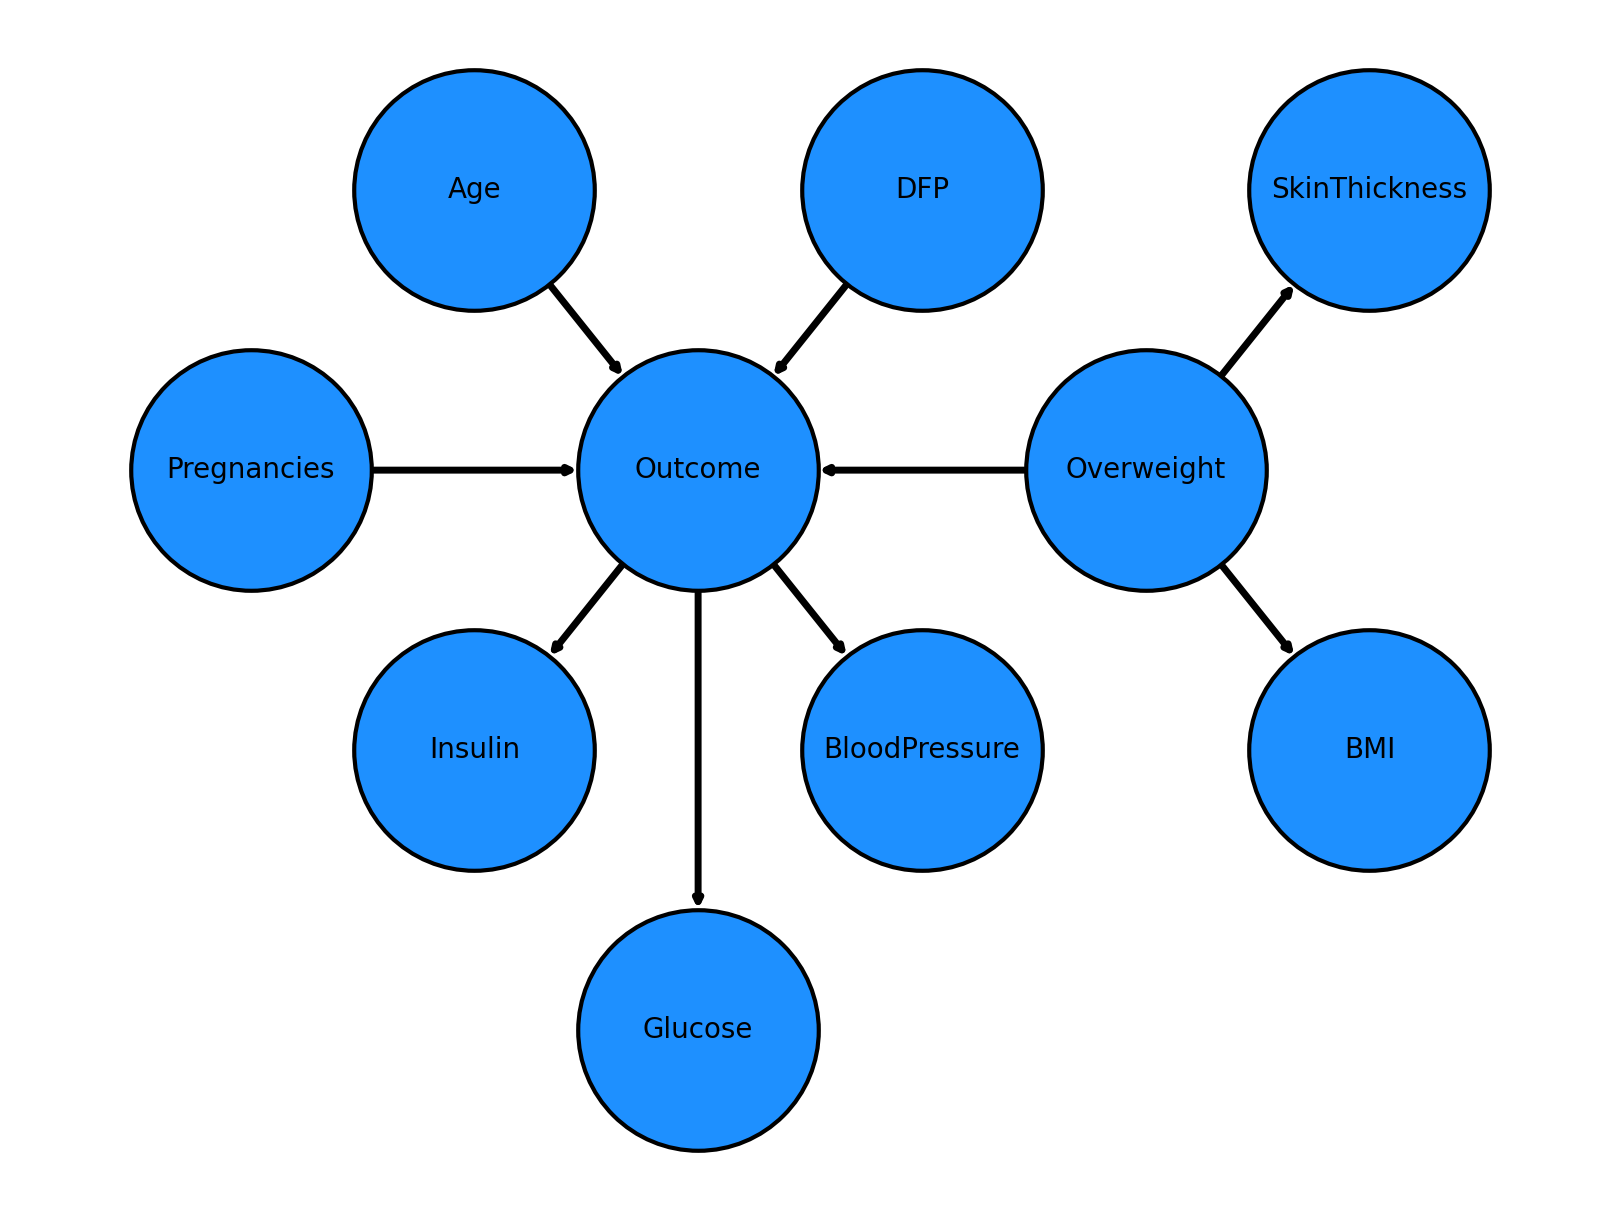

In [12]:
# Set node positions to match the reference diagram layout.
# Top row: Age (left), DiabetesPedigreeFunction (center), SkinThickness (right)
# Middle row: Pregnancies (far left), Outcome (center), Overweight (right)
# Bottom row: Insulin (left), BloodPressure (center), BMI (right)
# Very bottom: Glucose (center)
# Node IDs: 0=Overweight, 1=DiabetesPedigreeFunction, 2=Age, 3=Pregnancies, 
#           4=SkinThickness, 5=BMI, 6=Outcome, 7=BloodPressure, 8=Insulin, 9=Glucose

pos = {
    2: (-15, 30),        # Age - top left
    1: (15, 30),         # DiabetesPedigreeFunction - top center
    4: (45, 30),         # SkinThickness - top right
    3: (-30, 10),        # Pregnancies - middle far left
    6: (0, 10),          # Outcome/Diabetes - middle center (central node)
    0: (30, 10),         # Overweight - middle right
    8: (-15, -10),       # Insulin - bottom left
    7: (15, -10),        # BloodPressure - bottom center
    5: (45, -10),        # BMI - bottom right
    9: (0, -30)          # Glucose - very bottom center
}

# Create a larger figure for better visibility
plt.figure(figsize=(16, 12))

# Create custom labels - cambia el label del nodo 1 aquí
custom_labels = {
    0: 'Overweight',
    1: 'DFP',  # Cambia esto al label que desees para el nodo 1
    2: 'Age',
    3: 'Pregnancies',
    4: 'SkinThickness',
    5: 'BMI',
    6: 'Outcome',
    7: 'BloodPressure',
    8: 'Insulin',
    9: 'Glucose'
}

# Set options for graph looks. You might have to adjust these parameters.

options = {"font_size" : 20, "node_size" : 30000, "node_color" : "dodgerblue", 
           "edgecolors" : "black", "edge_color" : "black", "linewidths" : 3, 
           "width": 5}
    
# Generate graph.

n, d = bbn.to_nx_graph()

nx.draw(n, with_labels=True, labels=custom_labels, pos=pos, **options)

# Update margins and print the graph.

ax = plt.gca()
ax.margins(0.15)
plt.axis("off")
plt.tight_layout()
plt.show()

The goal of `print_probs` is to print out the probability distributions of all the nodes of the network. You can modify this code to print only the distributions of certain nodes if you find that helpful.

In [13]:
# Define a function for printing marginal probabilities.

def print_probs():
    for node in join_tree.get_bbn_nodes():
        potential = join_tree.get_bbn_potential(node)
        print("Node:", node)
        print("Values:")
        print(potential)
        print('----------------')
    
# Use the above function to print marginal probabilities.

print_probs()

Node: 0|Overweight|0,1
Values:
0=0|0.15300
0=1|0.84700
----------------
Node: 4|SkinThickness|1,2,3
Values:
4=1|0.48100
4=2|0.22900
4=3|0.29000
----------------
Node: 6|Outcome|0,1
Values:
6=0|0.61642
6=1|0.38358
----------------
Node: 8|Insulin|1,2,3
Values:
8=1|0.50082
8=2|0.23738
8=3|0.26180
----------------
Node: 5|BMI|0,1,2,3
Values:
5=0|0.25000
5=1|0.24900
5=2|0.25000
5=3|0.25100
----------------
Node: 7|BloodPressure|0,1,2,3
Values:
7=0|0.36919
7=1|0.24330
7=2|0.21404
7=3|0.17348
----------------
Node: 9|Glucose|0,1,2,3
Values:
9=0|0.22459
9=1|0.24961
9=2|0.25635
9=3|0.26945
----------------
Node: 1|DiabetesPedigreeFunction|0,1,2,3
Values:
1=0|0.24850
1=1|0.25100
1=2|0.24950
1=3|0.25100
----------------
Node: 2|Age|0,1,2,3
Values:
2=0|0.23050
2=1|0.25950
2=2|0.24700
2=3|0.26300
----------------
Node: 3|Pregnancies|0,1,2,3
Values:
3=0|0.15050
3=1|0.32000
3=2|0.26350
3=3|0.26600
----------------


The function `evidence` helps tyou to create evidence that will be used for making inferences. Do not modify this cell, please.

In [14]:
# To add evidence of events that happened so probability distribution can be recalculated.

def evidence(ev, nod, val, like):
    ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name(nod)) \
    .with_evidence(val, like) \
    .build()
    join_tree.set_observation(ev)

Now you are ready to add evidence and print out the new distributions of your network. 

In [15]:
# Use above function to add evidence.

evidence('ev1', 'Overweight', '1', 1)

# Print marginal probabilities.

print_probs()

Node: 0|Overweight|0,1
Values:
0=0|0.00000
0=1|1.00000
----------------
Node: 4|SkinThickness|1,2,3
Values:
4=1|0.40791
4=2|0.25620
4=3|0.33589
----------------
Node: 6|Outcome|0,1
Values:
6=0|0.58790
6=1|0.41210
----------------
Node: 8|Insulin|1,2,3
Values:
8=1|0.50173
8=2|0.23181
8=3|0.26646
----------------
Node: 5|BMI|0,1,2,3
Values:
5=0|0.11452
5=1|0.29398
5=2|0.29516
5=3|0.29634
----------------
Node: 7|BloodPressure|0,1,2,3
Values:
7=0|0.36350
7=1|0.24312
7=2|0.21639
7=3|0.17699
----------------
Node: 9|Glucose|0,1,2,3
Values:
9=0|0.21711
9=1|0.24557
9=2|0.25727
9=3|0.28005
----------------
Node: 1|DiabetesPedigreeFunction|0,1,2,3
Values:
1=0|0.24850
1=1|0.25100
1=2|0.24950
1=3|0.25100
----------------
Node: 2|Age|0,1,2,3
Values:
2=0|0.23050
2=1|0.25950
2=2|0.24700
2=3|0.26300
----------------
Node: 3|Pregnancies|0,1,2,3
Values:
3=0|0.15050
3=1|0.32000
3=2|0.26350
3=3|0.26600
----------------


If you need to reset the Bayesian network, rerun this line of code or rerun the above cell twice.

In [16]:
join_tree = InferenceController.apply(bbn)

## Project of the week

We are going to help a to person choose a certain food based on their **glycemic index** (GI), which is a number between 0 and 100, being pure glucose a food with a glycemic index of one hundred. Based on this index, foods are divided into three categories: *low GI* ($GI<55$), *medium GI* ($55\leq GI\leq69$), and *high GI* ($GI\geq70$). 

In order to do this, we will add a decision node and a utility node to the Bayesian network. For the decision node, we will have three actions: pick either a low GI food, a medium GI food, or a high GI food. As for the utility node, we have the following utility table:

<img src="utility.png" alt="Drawing" style="width: 500px;"/>

As we can see the `Diabetes` node is a parent of the utility node. 

Your mission is to, given some evidence, help a person to choose their diet among the available three options. As expected, this choice will be determined by the principle of **Maximum Expected Utility**.

To accomplish your mission, let us start by defining our set of actions and the possible states of the `Outcome` node.

In [17]:
actions = ['Low GI', 'Medium GI', 'High GI']
states = [0, 1]

In [18]:
def utility_function(state, action):

    """
    This function receives a state "s" and an action "a" and returns the corresponding value of the
    utility function, which is U(s,a).
    """
    
    # Utility table based on Diabetes state and Food choice
    utility_table = {
        0: {'Low GI': 60, 'Medium GI': 100, 'High GI': 80},
        1: {'Low GI': 100, 'Medium GI': 50, 'High GI': 0}
    }
    
    utility = utility_table[state][action]
    
    return utility

Now write a function that, given an evidence and a set of actions, returns the action that maximizes the expected utility.

In [19]:
def maximize_utility(probabilities):
    
    """
    This function finds the action that maximizes the expected utility. It receives the probabilities 
    of a random node, that would be the "Outcome" node in this case, and returns the optimal action.
    Notice that you will have to call the utility_function to obtain the desired action. 
    """
    
    max_expected_utility = -float('inf')
    best_action = None
    
    for action in actions:
        expected_utility = sum(probabilities[state] * utility_function(state, action) for state in states)
        
        if expected_utility > max_expected_utility:
            max_expected_utility = expected_utility
            best_action = action
    
    return best_action

## Testing the Utility and Maximization Functions

Let's test our functions with some simple examples to verify they work correctly.


In [20]:
# Example 1: Test utility_function directly
print("=" * 60)
print("Example 1: Utility Function Values")
print("=" * 60)

for state in states:
    print(f"\nOutcome state = {state} {'(Diabetic)' if state == 1 else '(Non-diabetic)'}")
    print("-" * 40)
    for action in actions:
        utility = utility_function(state, action)
        print(f"  U({state}, '{action}'): {utility}")


Example 1: Utility Function Values

Outcome state = 0 (Non-diabetic)
----------------------------------------
  U(0, 'Low GI'): 60
  U(0, 'Medium GI'): 100
  U(0, 'High GI'): 80

Outcome state = 1 (Diabetic)
----------------------------------------
  U(1, 'Low GI'): 100
  U(1, 'Medium GI'): 50
  U(1, 'High GI'): 0


In [21]:
# Example 2: Calculate Expected Utility for different probability distributions
print("\n" + "=" * 60)
print("Example 2: Expected Utility for Different Scenarios")
print("=" * 60)

# Scenario A: Person with no diabetes (probability of state 0 = 1.0)
print("\nScenario A: Non-diabetic person (P(state=0)=1.0, P(state=1)=0.0)")
print("-" * 40)
prob_scenario_a = {0: 1.0, 1: 0.0}
for action in actions:
    eu = sum(prob_scenario_a[state] * utility_function(state, action) for state in states)
    print(f"  EU('{action}'): {eu:.1f}")

best_action_a = maximize_utility(prob_scenario_a)
print(f"\n  ✓ Optimal action: '{best_action_a}'")

# Scenario B: Person with diabetes (probability of state 1 = 1.0)
print("\n\nScenario B: Diabetic person (P(state=0)=0.0, P(state=1)=1.0)")
print("-" * 40)
prob_scenario_b = {0: 0.0, 1: 1.0}
for action in actions:
    eu = sum(prob_scenario_b[state] * utility_function(state, action) for state in states)
    print(f"  EU('{action}'): {eu:.1f}")

best_action_b = maximize_utility(prob_scenario_b)
print(f"\n  ✓ Optimal action: '{best_action_b}'")

# Scenario C: Uncertain case (equal probability of both states)
print("\n\nScenario C: Uncertain case (P(state=0)=0.5, P(state=1)=0.5)")
print("-" * 40)
prob_scenario_c = {0: 0.5, 1: 0.5}
for action in actions:
    eu = sum(prob_scenario_c[state] * utility_function(state, action) for state in states)
    print(f"  EU('{action}'): {eu:.1f}")

best_action_c = maximize_utility(prob_scenario_c)
print(f"\n  ✓ Optimal action: '{best_action_c}'")



Example 2: Expected Utility for Different Scenarios

Scenario A: Non-diabetic person (P(state=0)=1.0, P(state=1)=0.0)
----------------------------------------
  EU('Low GI'): 60.0
  EU('Medium GI'): 100.0
  EU('High GI'): 80.0

  ✓ Optimal action: 'Medium GI'


Scenario B: Diabetic person (P(state=0)=0.0, P(state=1)=1.0)
----------------------------------------
  EU('Low GI'): 100.0
  EU('Medium GI'): 50.0
  EU('High GI'): 0.0

  ✓ Optimal action: 'Low GI'


Scenario C: Uncertain case (P(state=0)=0.5, P(state=1)=0.5)
----------------------------------------
  EU('Low GI'): 80.0
  EU('Medium GI'): 75.0
  EU('High GI'): 40.0

  ✓ Optimal action: 'Low GI'
